In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from pandas import Grouper


import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

# EDA

This dataset includes PV power production measured on the SolarTech Lab, Politecnico di Milano, Italy. Data are freely available for scientific research purpose and further data validation.

In particular, the cleaned dataset is composed of the following variables and specifics, with a time resolution of 1 hour:

- Time: column with time recordings; the data format is “dd-MM-yyyy hh:mm:ss”, with the time always expressed in Central European Time (CET).
- PV_Power: power recordings from the PV module (W); module tilt: 30°.
- T_air: ambient temperature (°C) measured by the weather station described in SolarTech Lab website (http://www.solartech.polimi.it/instrumentation/).
- G_h: measured Global Horizontal Irradiance (W/m2).
- G_tilt: global irradiance measured on the plane of array (30°).
- W_s: measured wind speed (m/s).
- W_d: measured wind direction (°), assuming 0° east, positive south.


Let's read our cleaned dataset.

In [3]:
df = pd.read_csv('cleaned_data.csv', parse_dates=True, index_col='Time')

<Axes: xlabel='Time'>

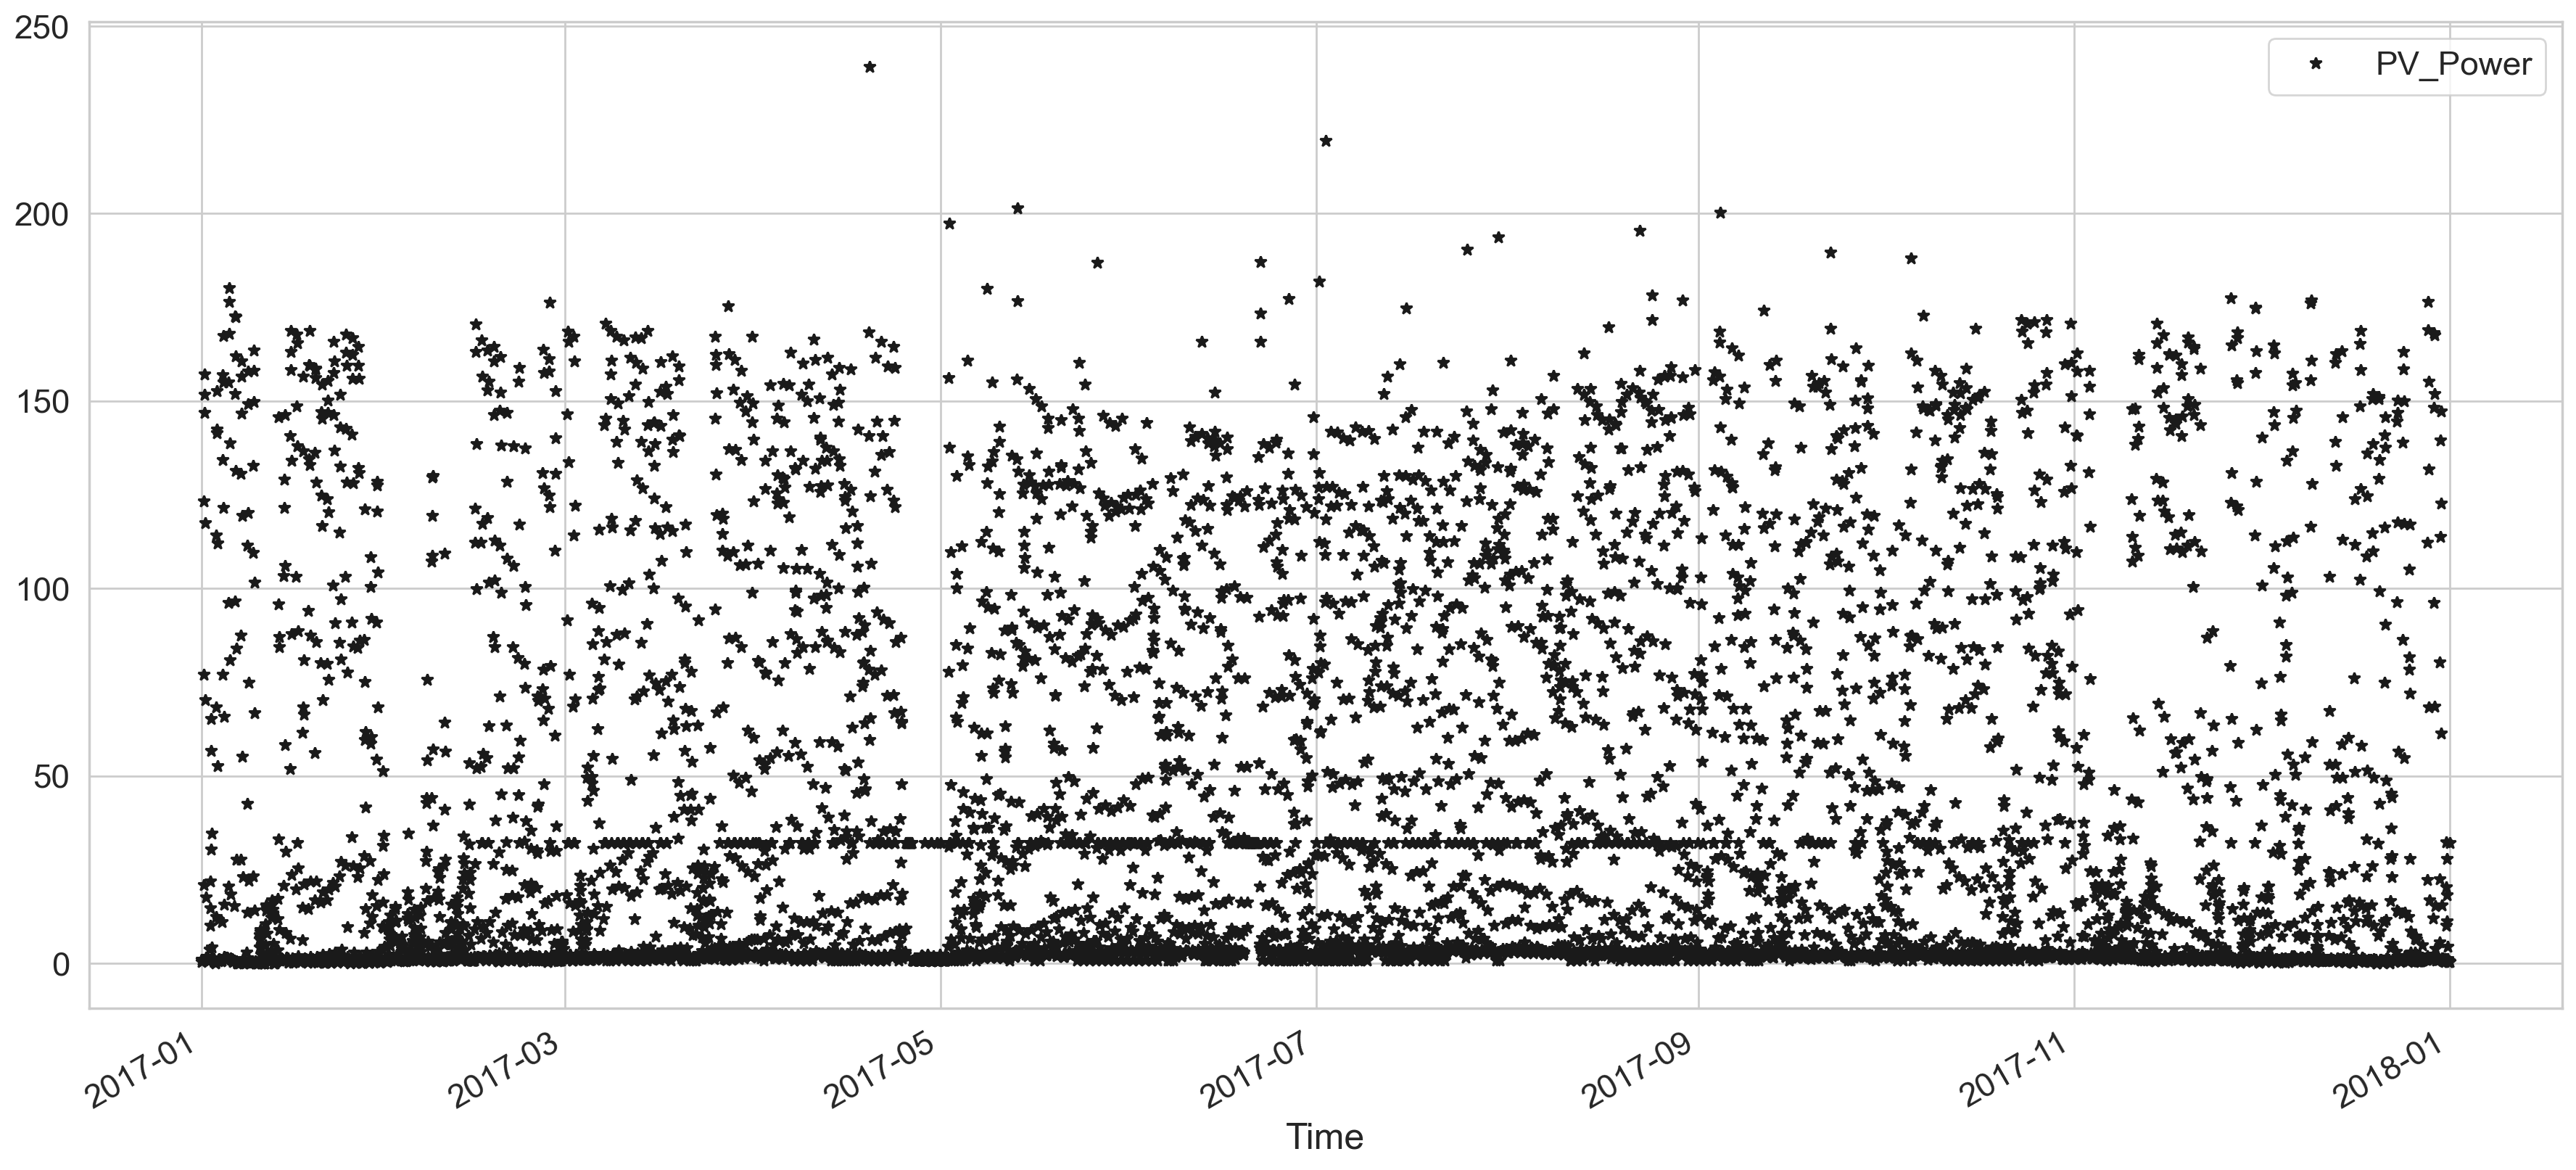

In [ ]:
df.plot(y='PV_Power', style='k*')

# Histogram and Density Plots

<Axes: >

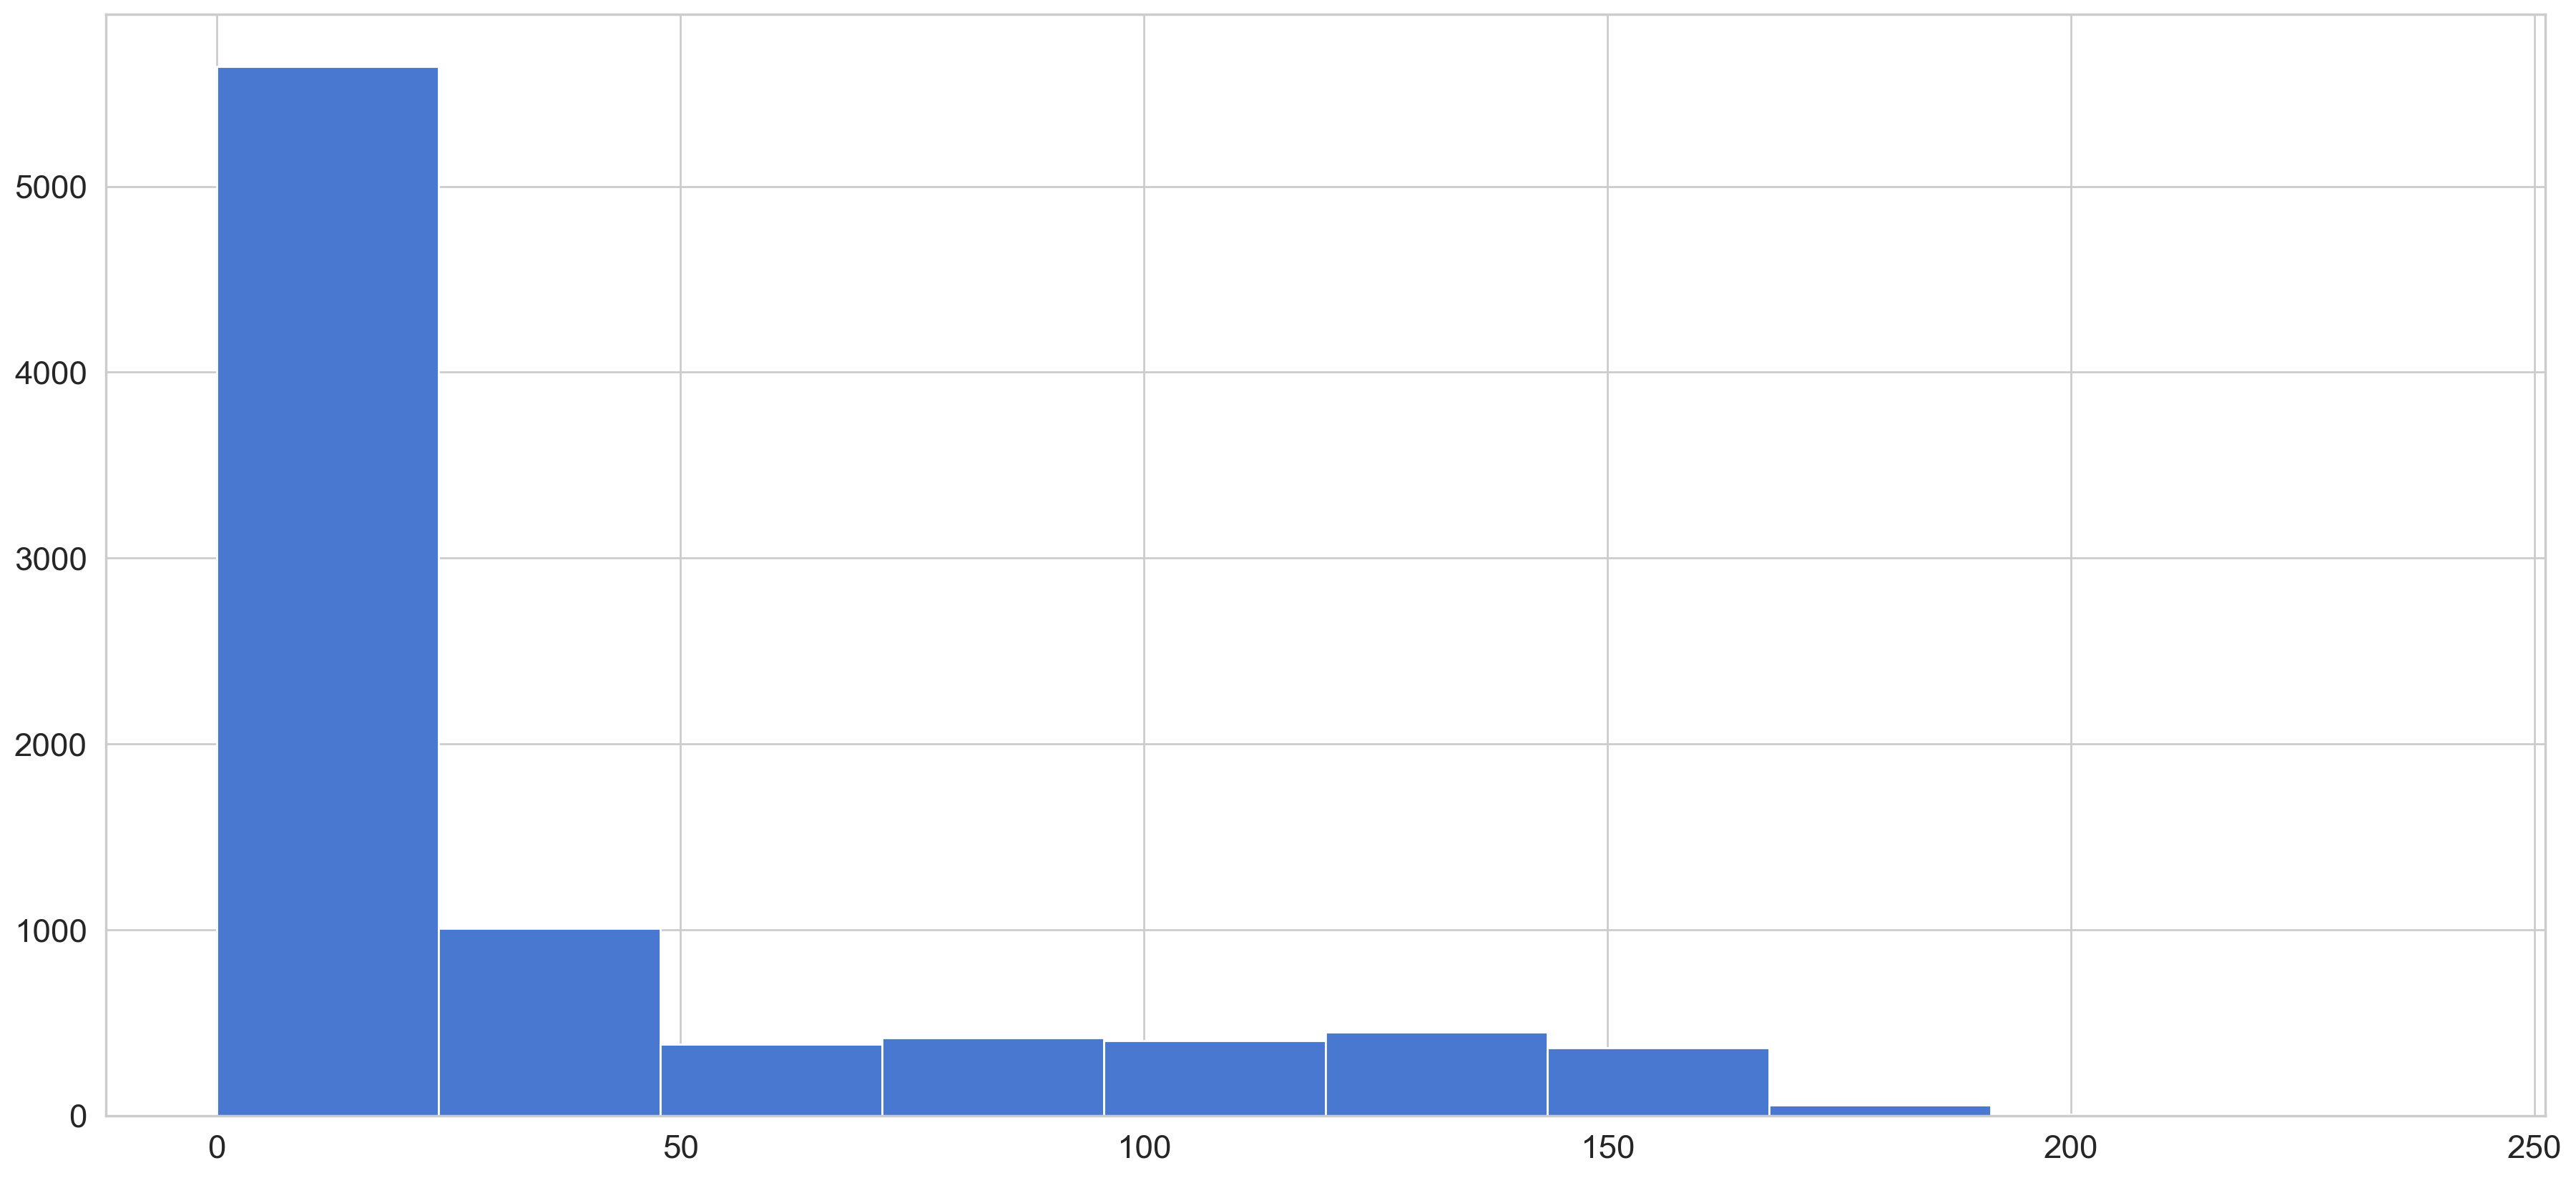

In [5]:
pv = df['PV_Power']
pv.hist()

<Axes: ylabel='Density'>

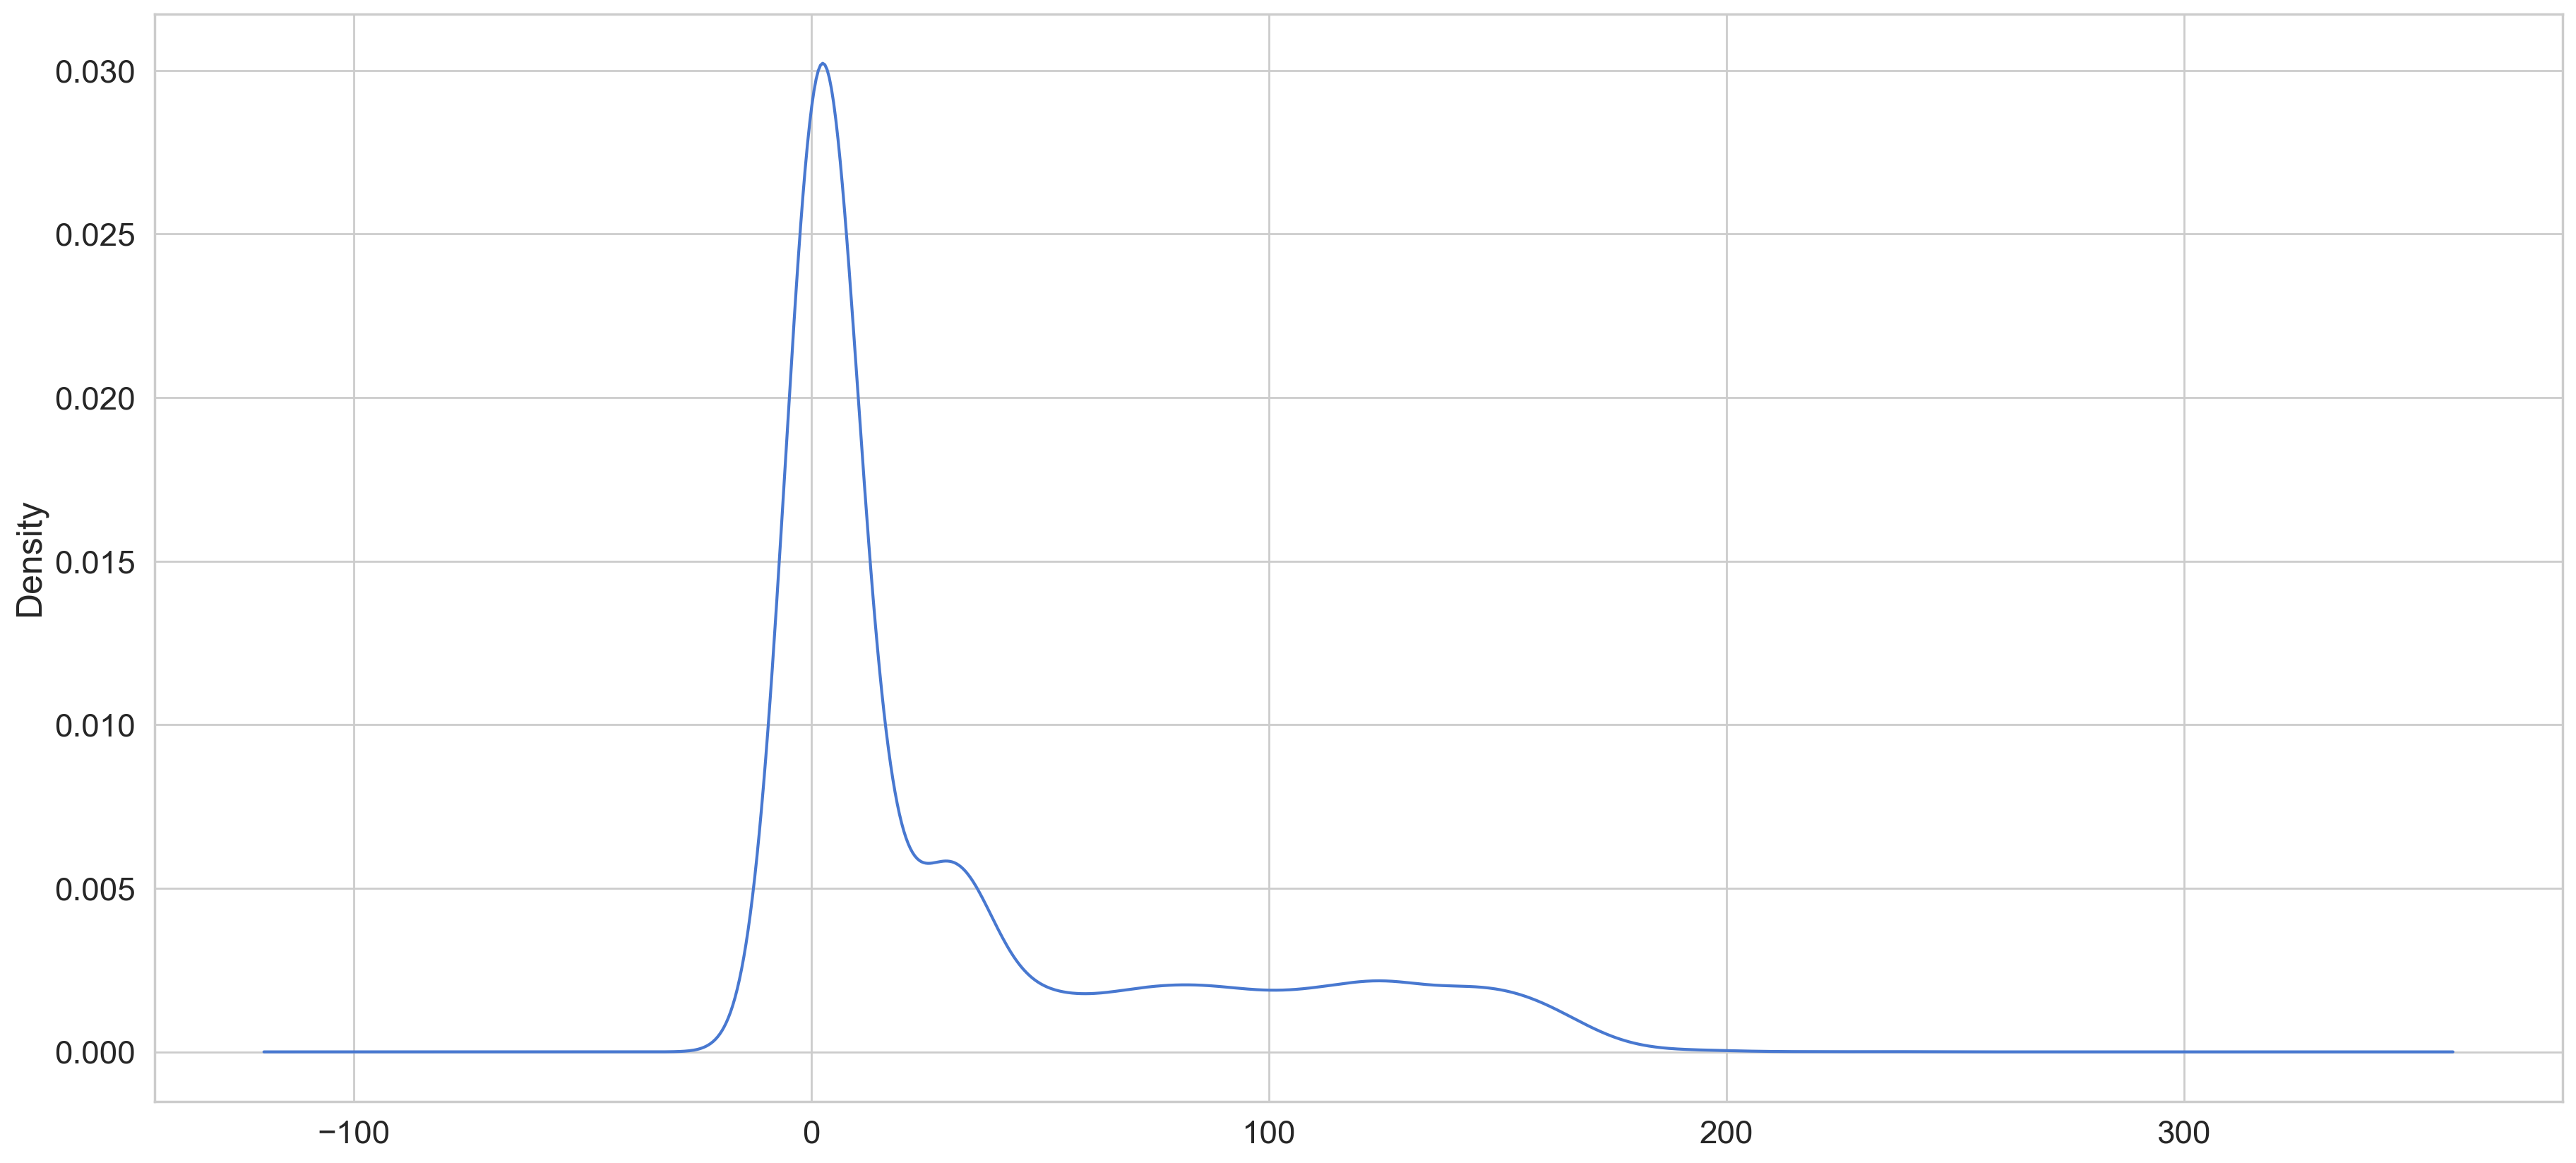

In [6]:
pv.plot(kind='kde')

Add some standard features based on time.

In [7]:
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday
df['dayofmonth'] = df.index.day
df['month'] = df.index.month

df.head()

,PV_Power,T_air,G_h,G_tilt,W_s,W_d,hour,weekday,dayofmonth,month
Time,,,,,,,,,,
2017-01-01 00:00:00,1.055644,0.791833,0.0,0.0,0.291333,286.755000,0,6,1,1
2017-01-01 01:00:00,0.450760,0.366833,0.0,0.0,0.351333,162.585000,1,6,1,1
2017-01-01 02:00:00,0.920027,0.158167,0.0,0.0,0.187833,272.215000,2,6,1,1
2017-01-01 03:00:00,0.826160,-0.029167,0.0,0.0,0.262500,255.946667,3,6,1,1
2017-01-01 04:00:00,1.031269,-0.210000,0.0,0.0,0.238833,306.080000,4,6,1,1


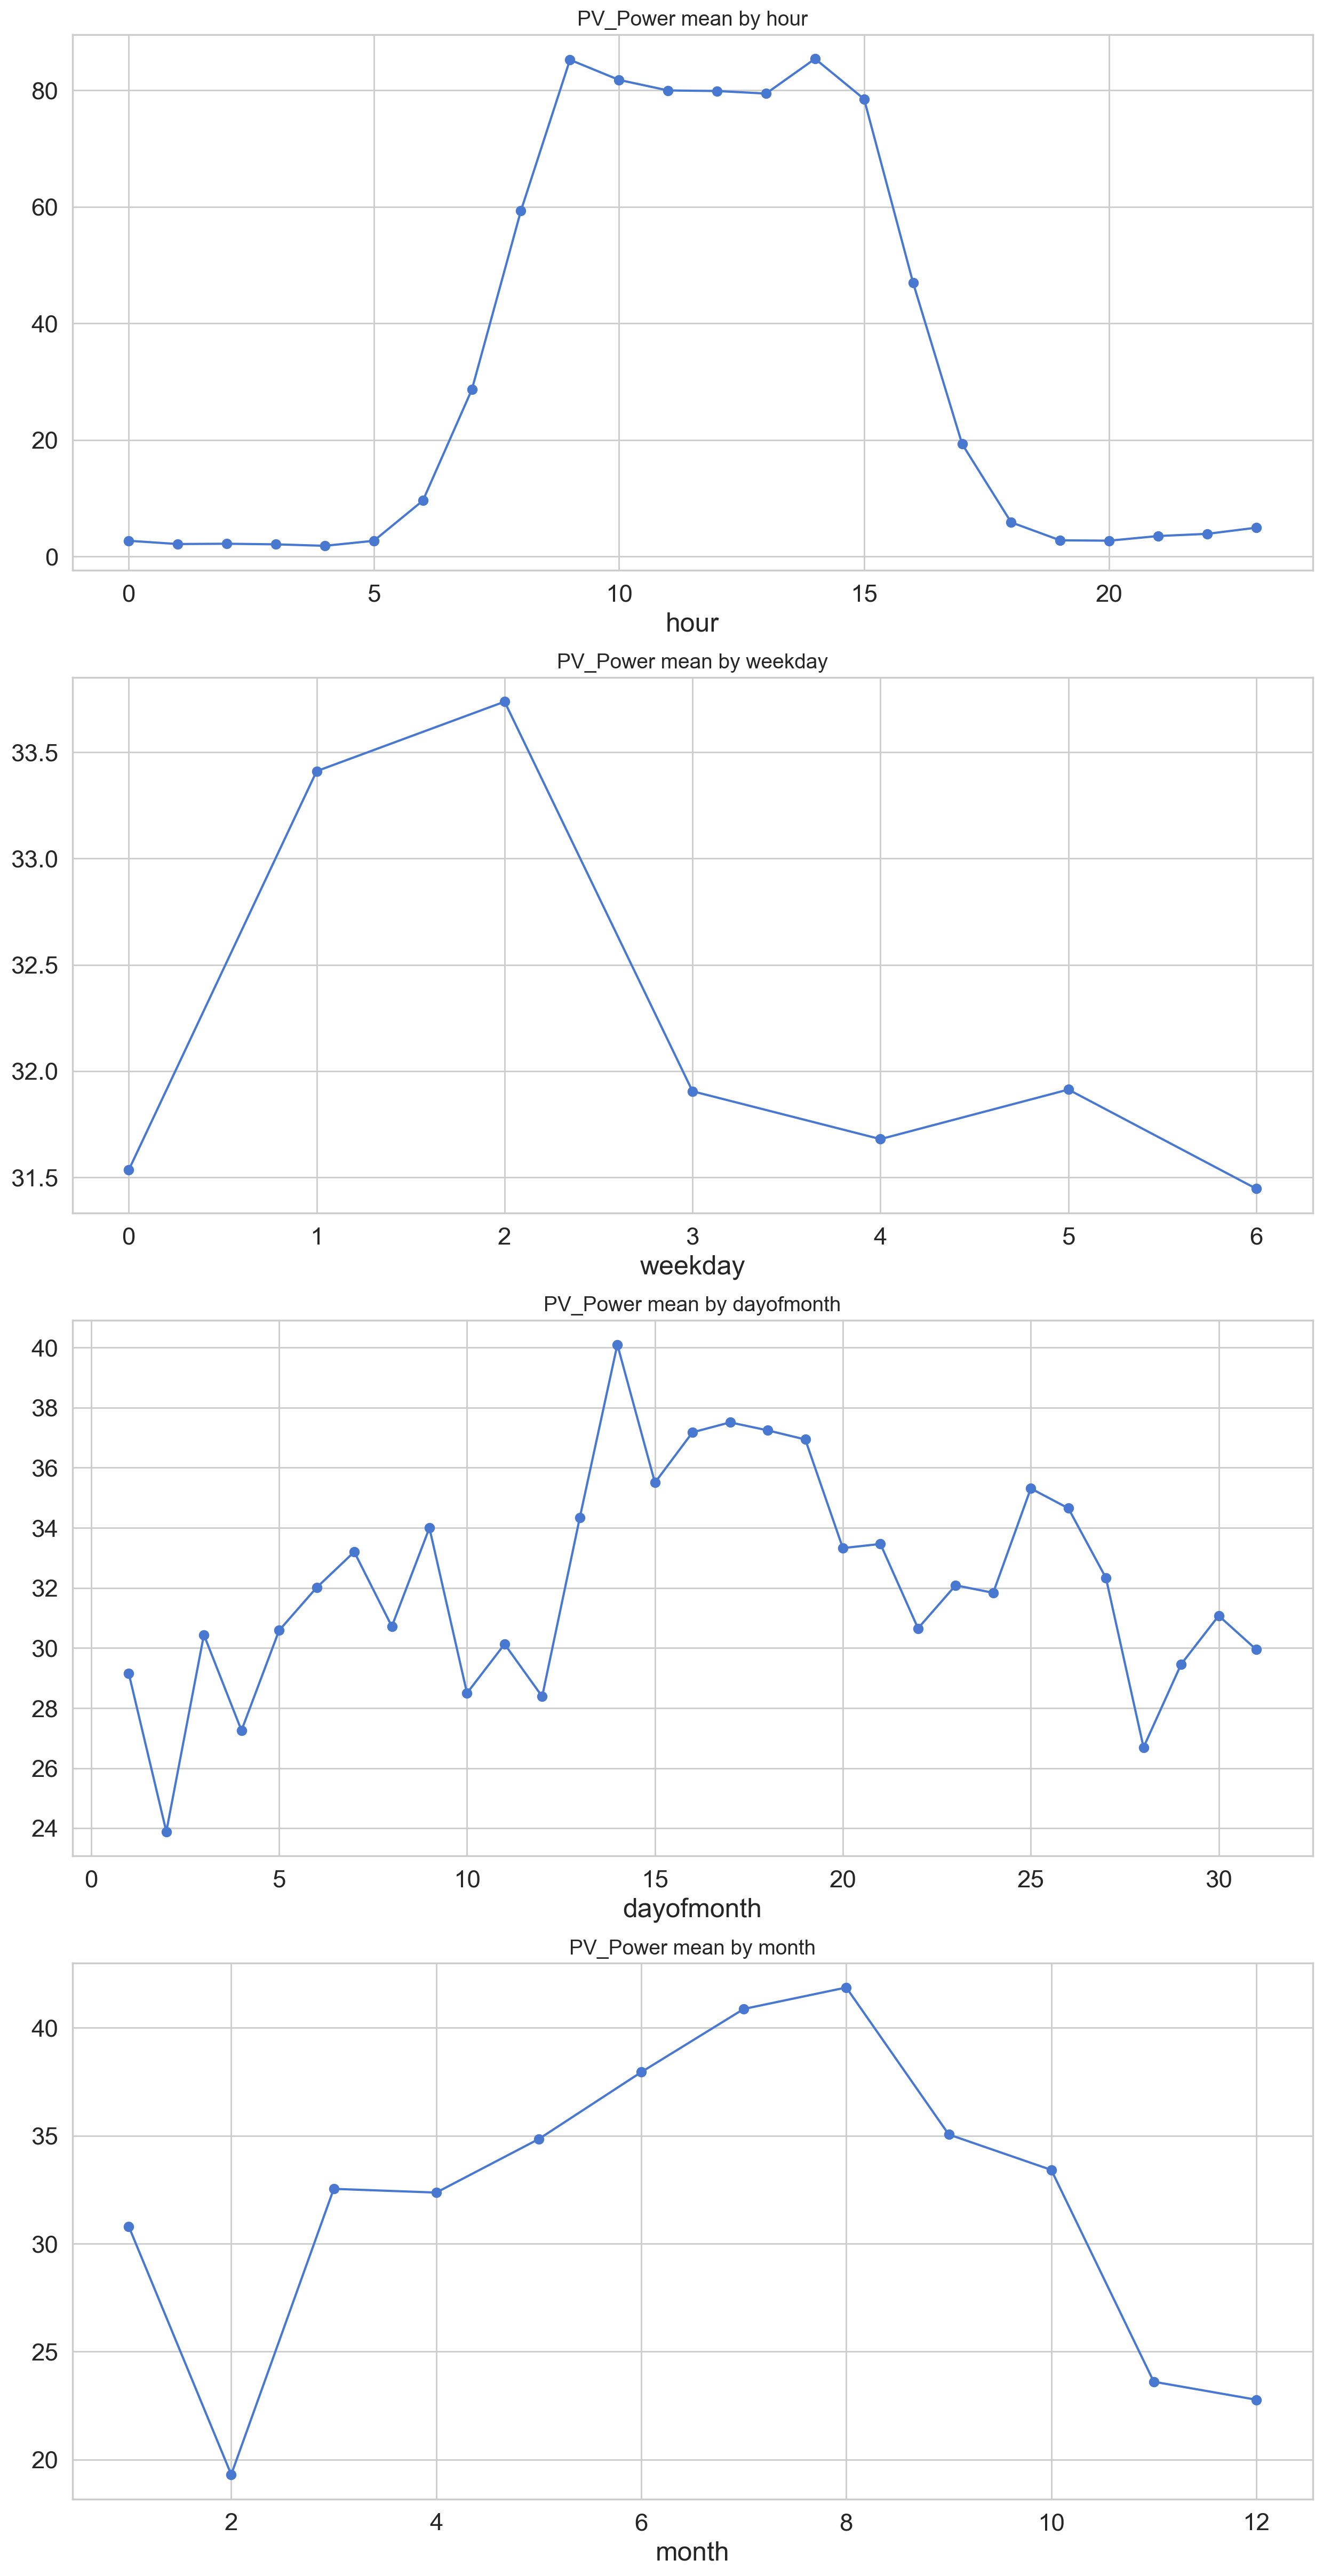

In [8]:
groups = ['hour', 'weekday', 'dayofmonth', 'month']

fig, ax = plt.subplots(len(groups), 1, figsize=(15,30))

for group, ax in zip(groups, ax.flatten()):
    grouped = df.groupby(group)['PV_Power'].mean()
    ax.set_title(f'PV_Power mean by {group}', fontsize=14)
    grouped.plot(ax=ax, marker='o')

As expected the most useful time feature seems to be the hour of the day. The rest are not so useful.

# Lag Scatter Plot

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

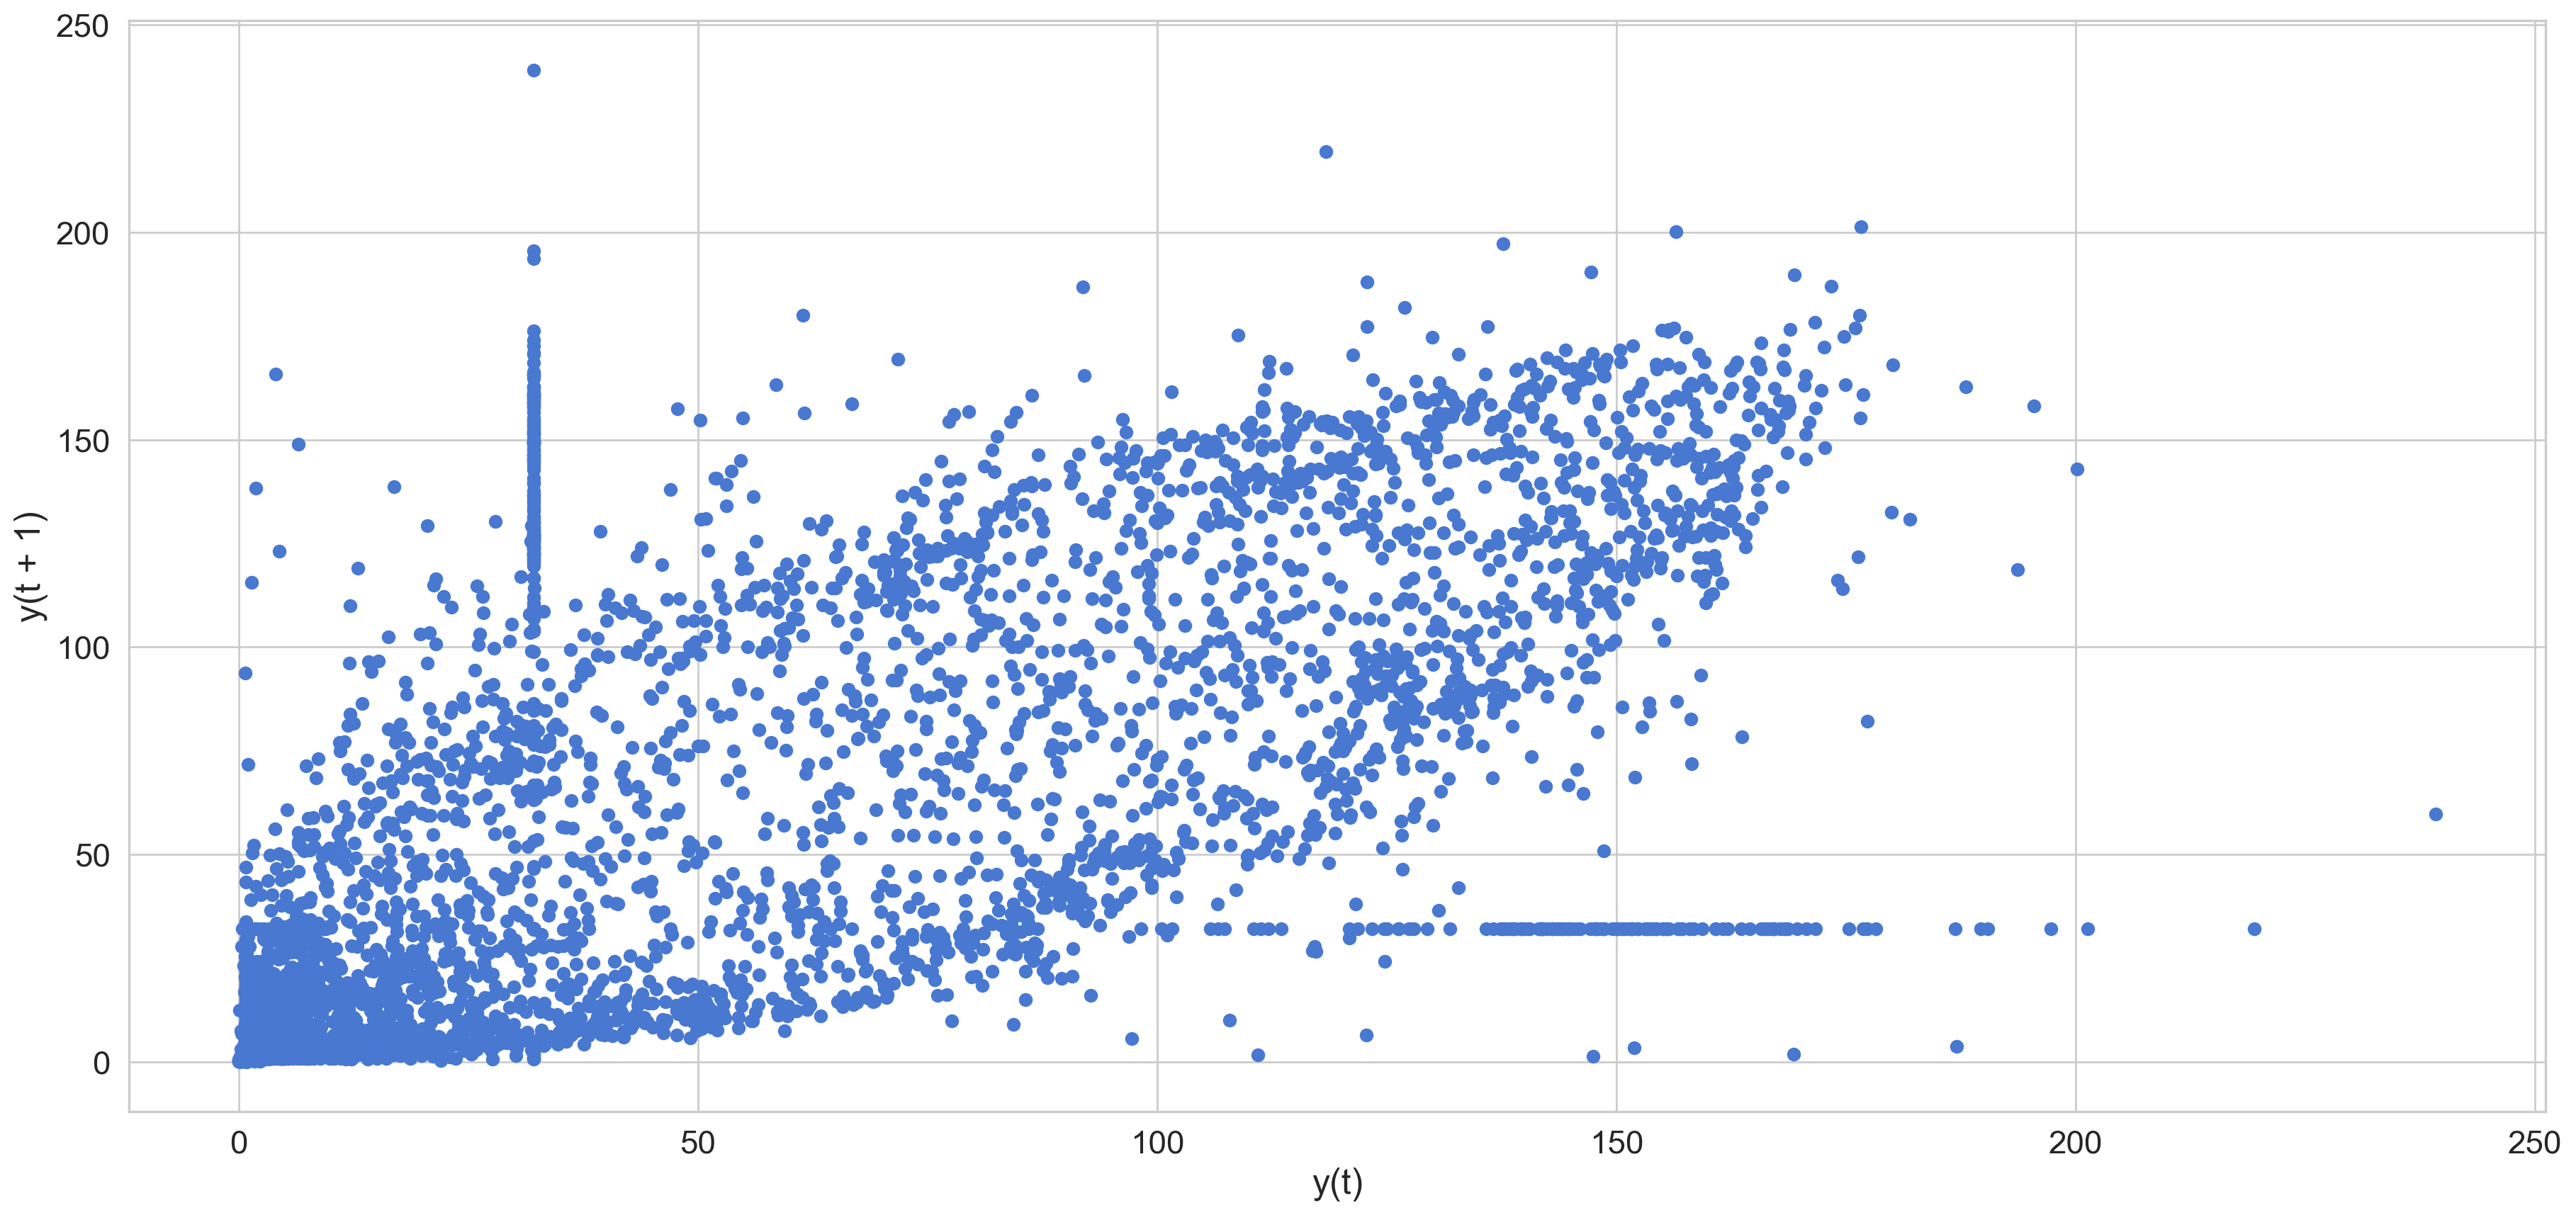

In [9]:
pd.plotting.lag_plot(pv)


# Autocorrelation plot

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

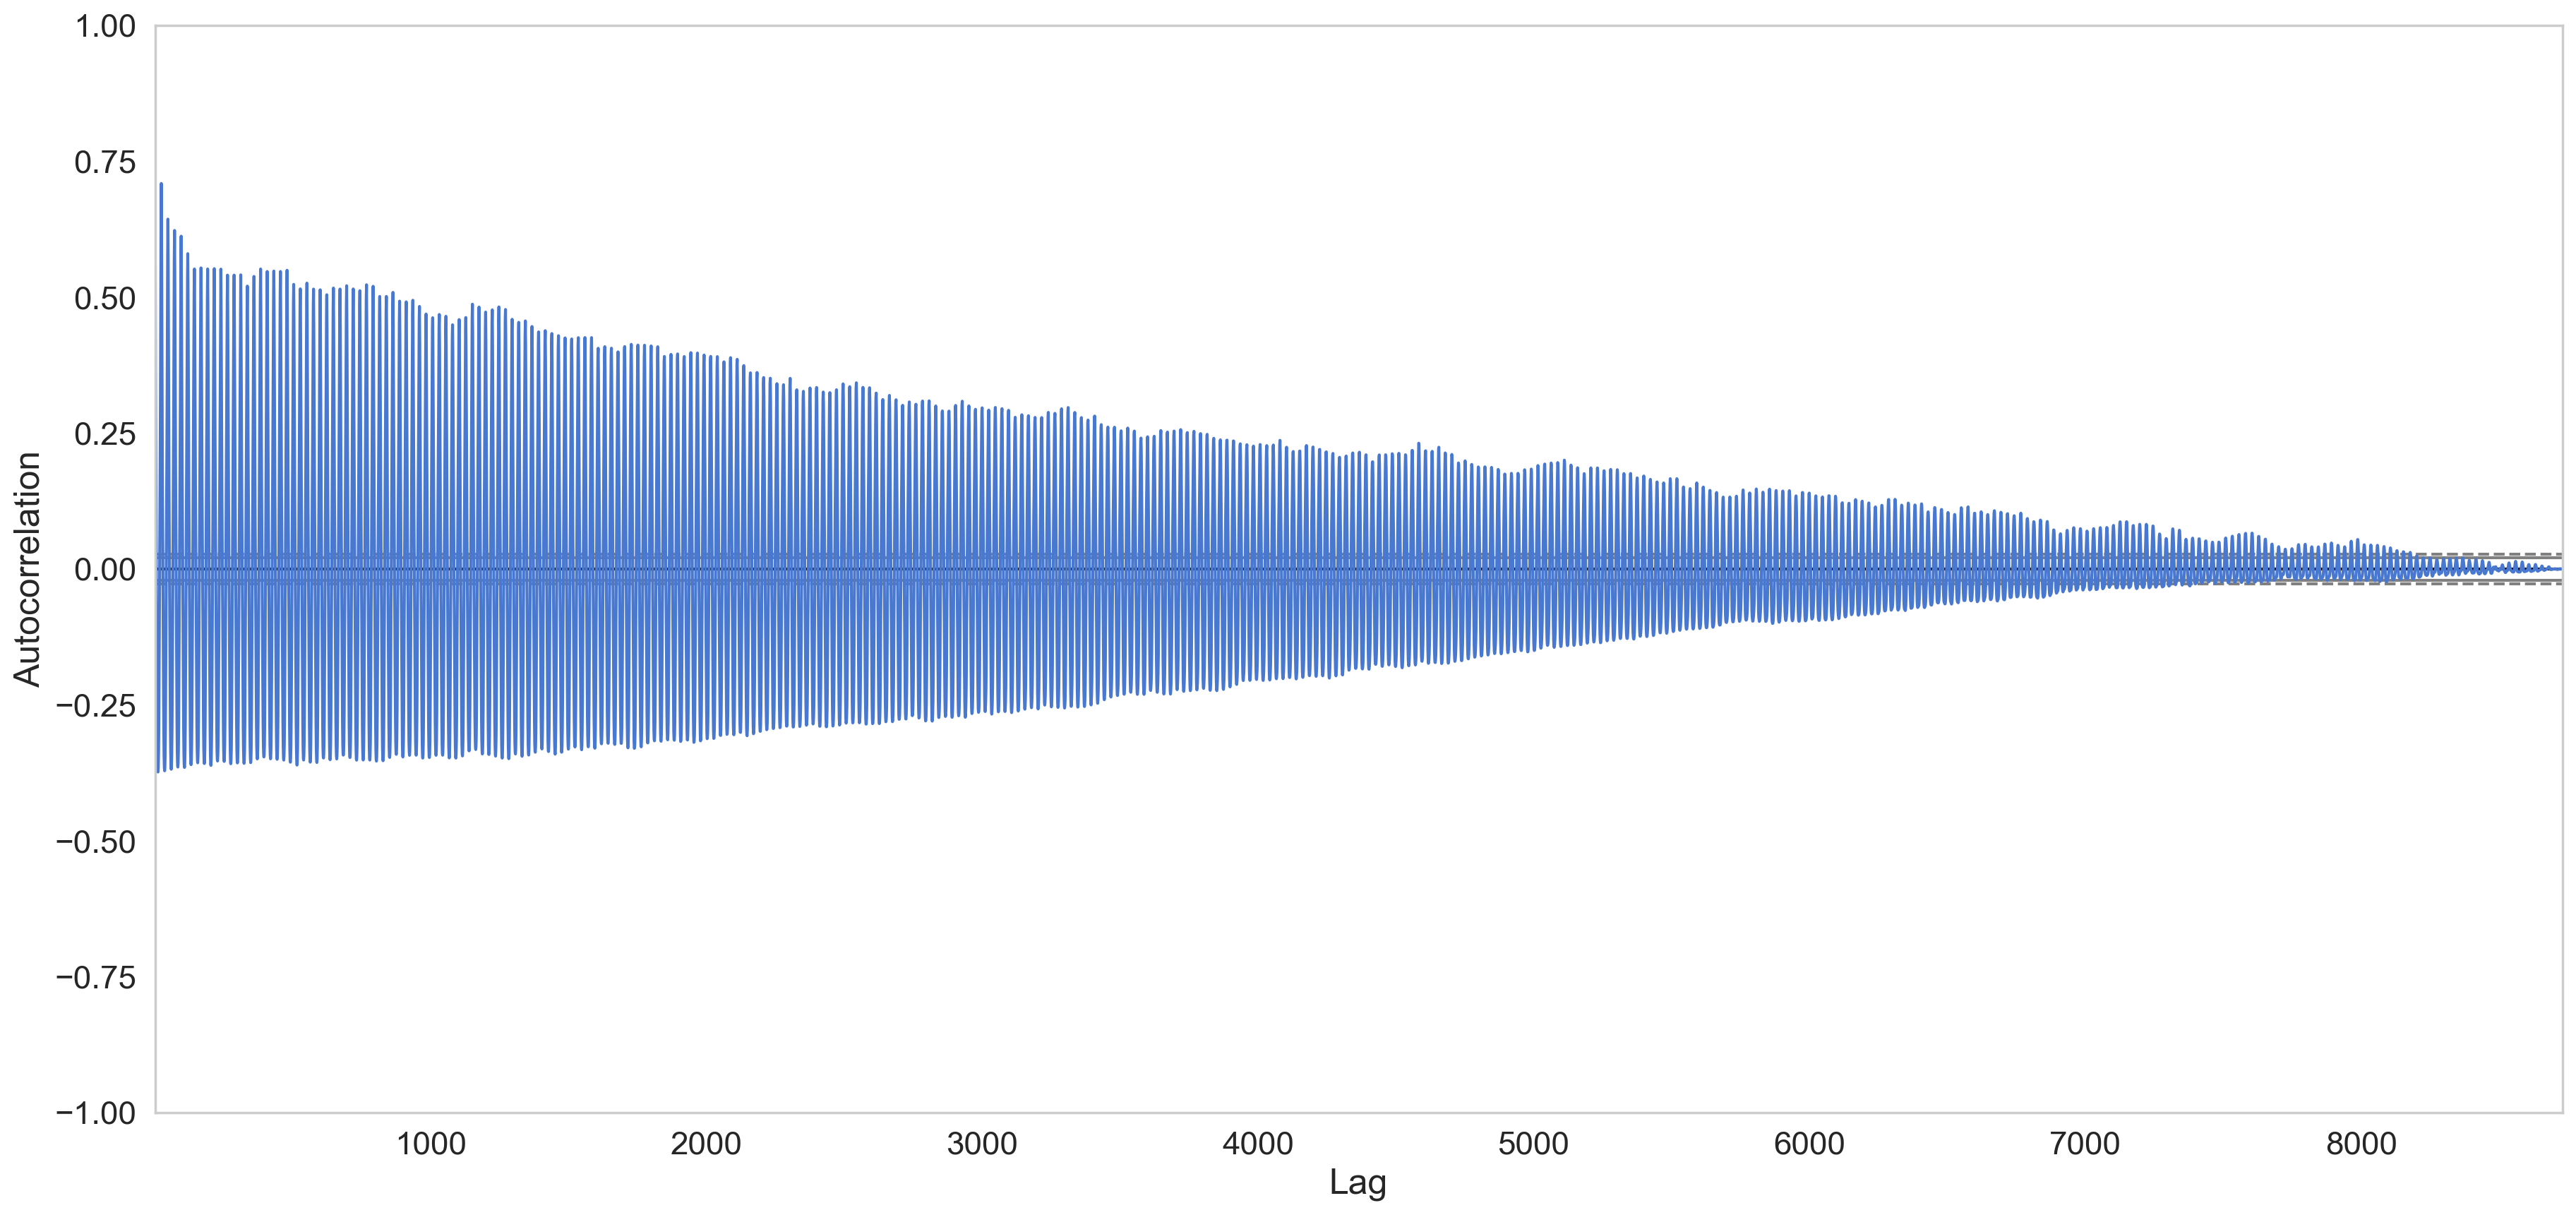

In [10]:
pd.plotting.autocorrelation_plot(pv)

# Correlation matrix

<Axes: >

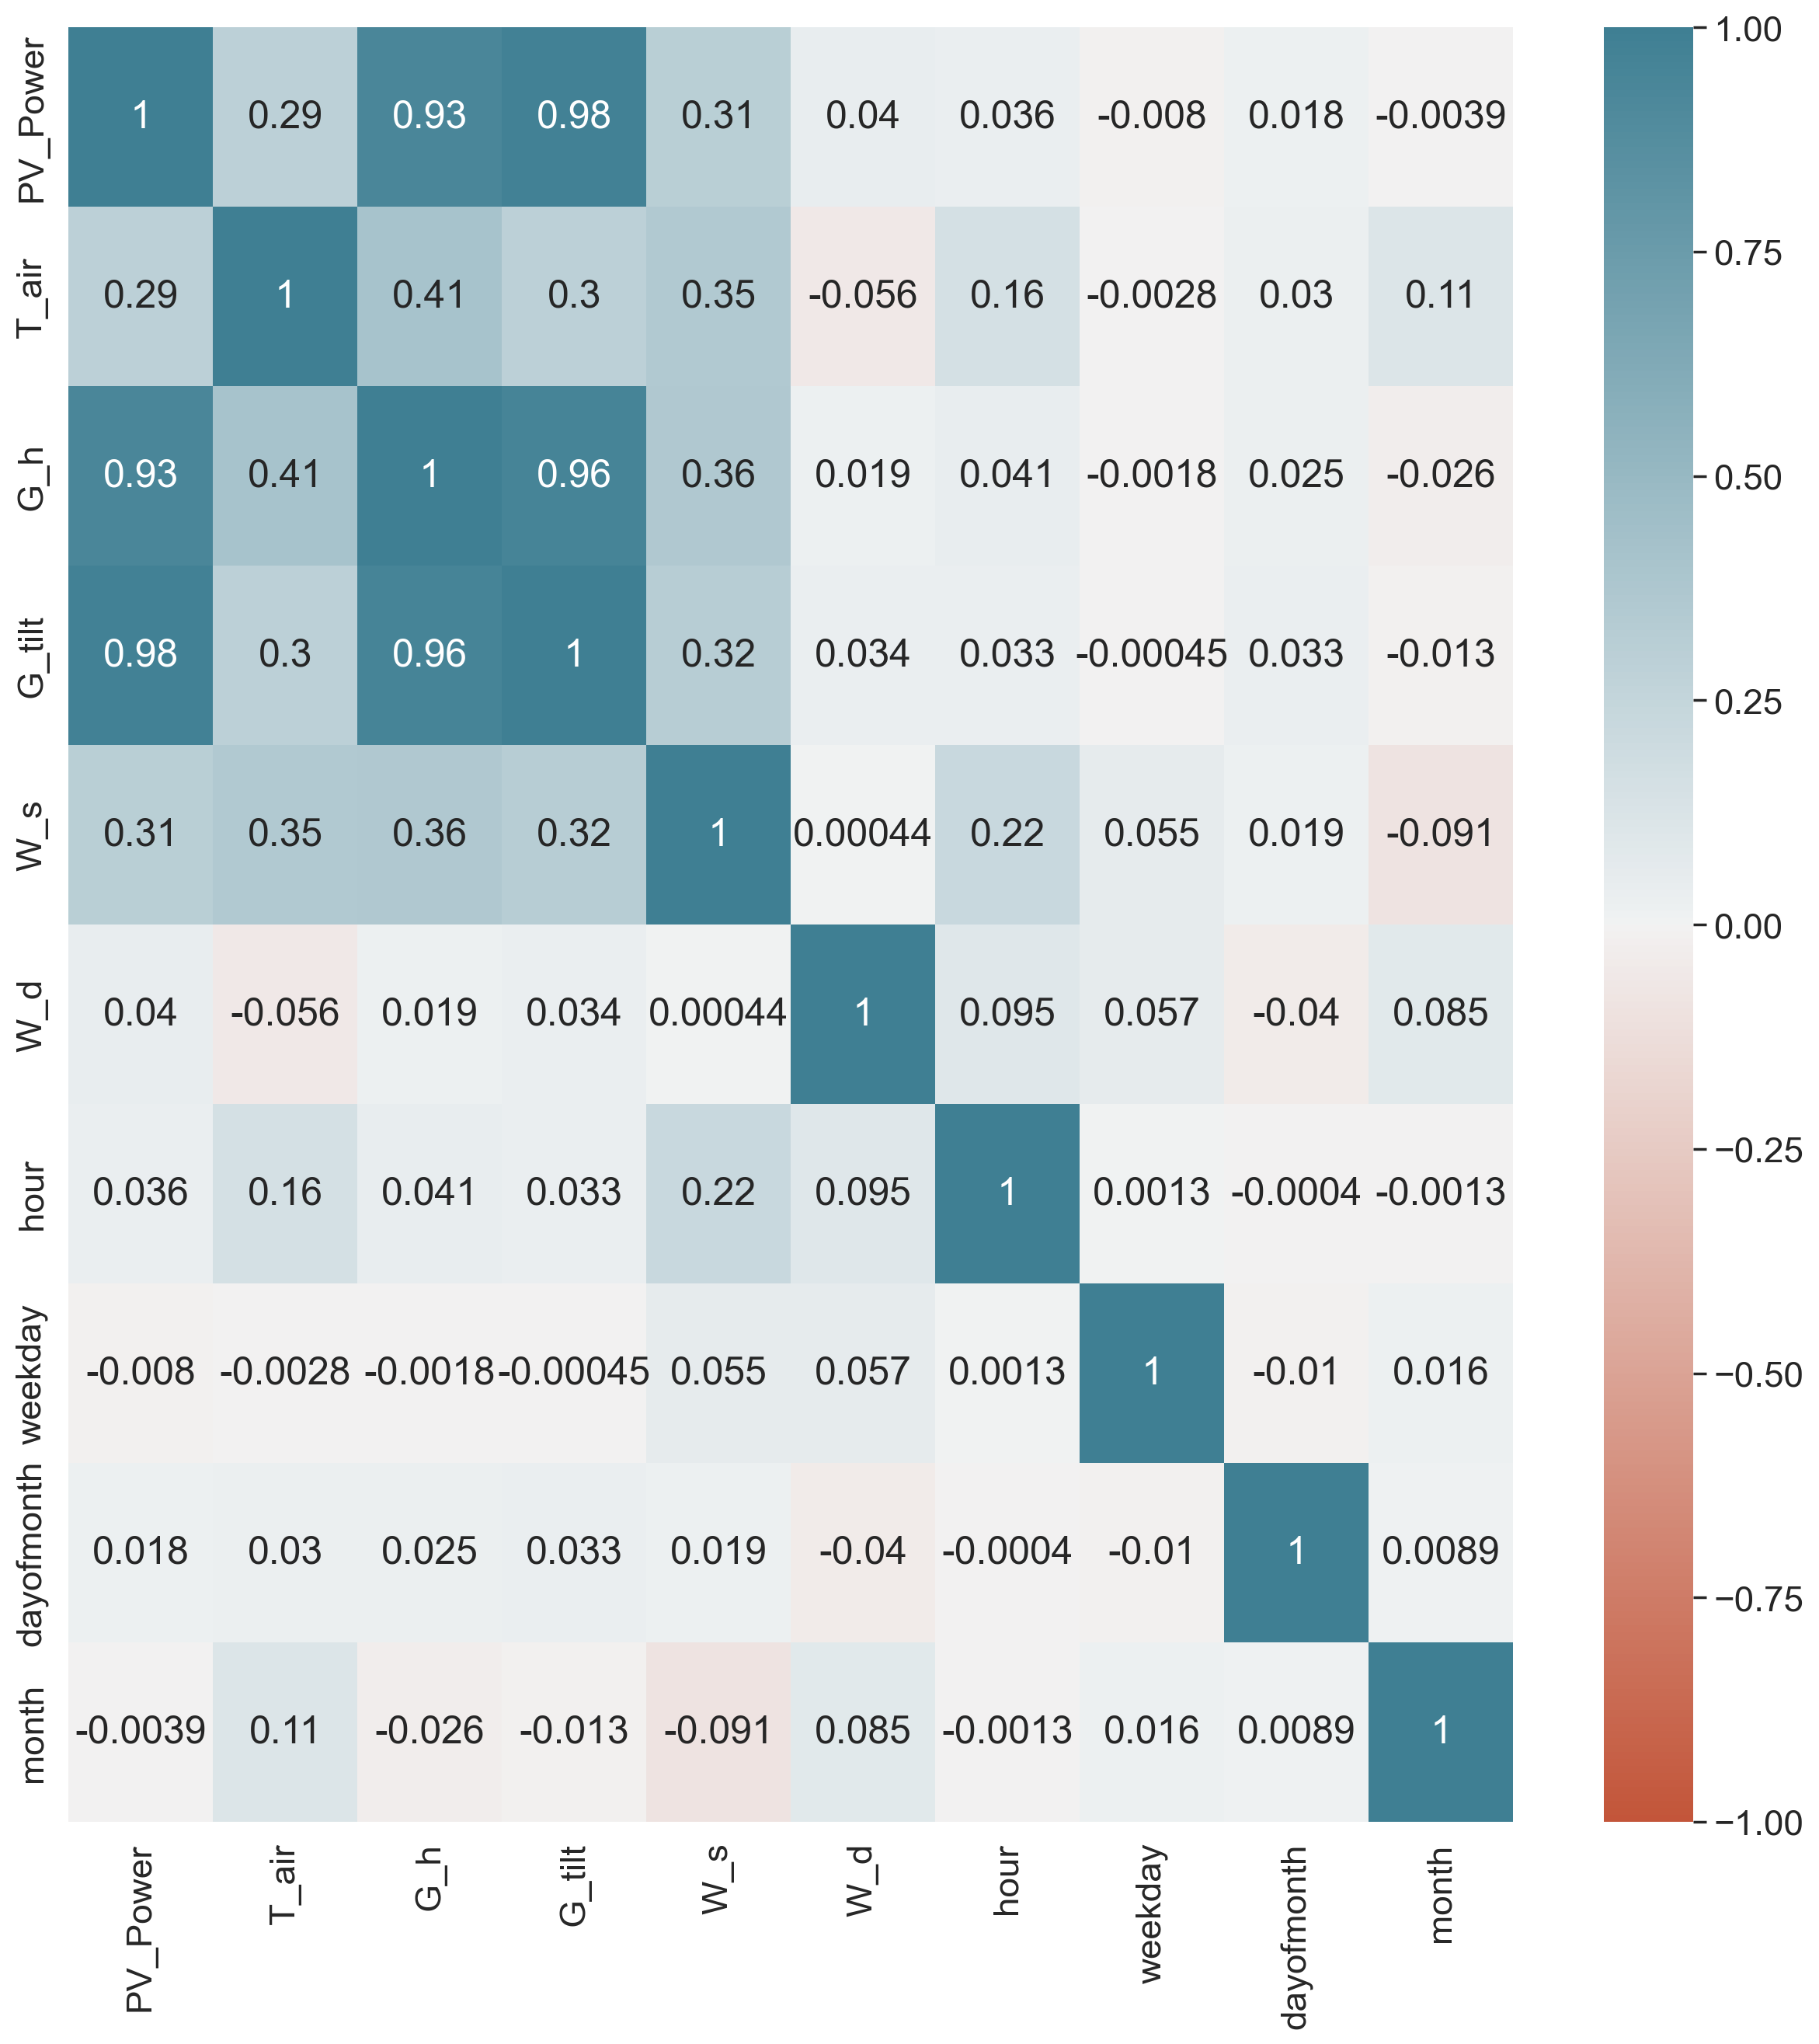

In [11]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True,
            cmap=sns.diverging_palette(20,220, as_cmap=True))

G_tilt and G_h seem to be the most correlated, which make sense they're measures of irradiance.

# feature importances

In [8]:
from sklearn.ensemble import RandomForestRegressor
rnd_reg = RandomForestRegressor(n_estimators=500, n_jobs=-1)
rnd_reg.fit(df.iloc[:, 1:], df.iloc[:, 0])

RandomForestRegressor(n_estimators=500, n_jobs=-1)

In [9]:
features = ['T_air', 'G_h', 'G_tilt', 'W_s', 'W_d', 'hour', 'weekday',
       'dayofmonth', 'month']
for name, score in zip(features, rnd_reg.feature_importances_):
    print(name, score)

T_air 0.009125889955306547
G_h 0.0035311071756114346
G_tilt 0.9631541815525733
W_s 0.0038257605295907407
W_d 0.007485741390274368
hour 0.0028961702570967107
weekday 0.001942849237754124
dayofmonth 0.004981005042370894
month 0.003057294859421947


In [12]:
def add_lags(df):
    target_map = df['PV_Power'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('1 hour')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('2 hour')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('3 hour')).map(target_map)
    df['lag4'] = (df.index - pd.Timedelta('6 hour')).map(target_map)

    return df

In [11]:
df = add_lags(df)

In [12]:
df.head()
df = df.dropna()

In [13]:
from sklearn.ensemble import RandomForestRegressor
rnd_reg = RandomForestRegressor(n_estimators=500, n_jobs=-1)
rnd_reg.fit(df.iloc[:, 1:], df.iloc[:, 0])

RandomForestRegressor(n_estimators=500, n_jobs=-1)

In [14]:
features = ['T_air', 'G_h', 'G_tilt', 'W_s', 'W_d', 'hour', 'weekday',
       'dayofmonth', 'month', 'lag1', 'lag2', 'lag3', 'lag4']
for name, score in zip(features, rnd_reg.feature_importances_):
    print(name, score)

T_air 0.003035805054521791
G_h 0.0012487840260208844
G_tilt 0.9597053513074848
W_s 0.0016279586506757762
W_d 0.0024109478421594625
hour 0.003002519543283982
weekday 0.0004954947690305268
dayofmonth 0.0010667803839790578
month 0.00043944663393285496
lag1 0.018352590185252288
lag2 0.004722371059829469
lag3 0.0022947966392260206
lag4 0.0015971539046032645


In [13]:
# Spearman’s Rank Correlation

from numpy.random import rand
from numpy.random import seed
from scipy.stats import spearmanr

seed(1)

df = pd.read_csv('cleaned_data.csv', parse_dates=True, index_col='Time')
df = add_lags(df)

df['hour'] = df.index.hour
df['month'] = df.index.month

df.head()

,PV_Power,T_air,G_h,G_tilt,W_s,W_d,lag1,lag2,lag3,lag4,hour,month
Time,,,,,,,,,,,,
2017-01-01 00:00:00,1.055644,0.791833,0.0,0.0,0.291333,286.755000,NaN,NaN,NaN,NaN,0,1
2017-01-01 01:00:00,0.450760,0.366833,0.0,0.0,0.351333,162.585000,1.055644,NaN,NaN,NaN,1,1
2017-01-01 02:00:00,0.920027,0.158167,0.0,0.0,0.187833,272.215000,0.450760,1.055644,NaN,NaN,2,1
2017-01-01 03:00:00,0.826160,-0.029167,0.0,0.0,0.262500,255.946667,0.920027,0.450760,1.055644,NaN,3,1
2017-01-01 04:00:00,1.031269,-0.210000,0.0,0.0,0.238833,306.080000,0.826160,0.920027,0.450760,NaN,4,1


In [15]:
df = df.dropna()
df.head()

,PV_Power,T_air,G_h,G_tilt,W_s,W_d,lag1,lag2,lag3,lag4,hour,month
Time,,,,,,,,,,,,
2017-01-01 06:00:00,0.790304,-0.858833,0.00,0.000000,0.348167,268.465000,1.001560,1.031269,0.826160,1.055644,6,1
2017-01-01 07:00:00,0.826171,-0.479167,0.10,0.133333,0.130333,260.481667,0.790304,1.001560,1.031269,0.450760,7,1
2017-01-01 08:00:00,20.945110,-0.989500,34.90,86.066667,0.372167,285.135000,0.826171,0.790304,1.001560,0.920027,8,1
2017-01-01 09:00:00,76.983555,-0.137167,148.45,328.050000,0.442833,278.855000,20.945110,0.826171,0.790304,0.826160,9,1
2017-01-01 10:00:00,123.238867,1.289833,267.50,531.383333,1.246667,249.785000,76.983555,20.945110,0.826171,1.031269,10,1


In [16]:
df.corr(numeric_only=True, method='spearman')

,PV_Power,T_air,G_h,G_tilt,W_s,W_d,lag1,lag2,lag3,lag4,hour,month
PV_Power,1.000000,0.493252,0.819386,0.841822,0.359371,0.058528,0.874918,0.733832,0.571897,0.126369,0.093263,0.018064
T_air,0.493252,1.000000,0.319449,0.288550,0.348912,-0.080661,0.516982,0.526165,0.523055,0.483811,0.143108,0.099673
G_h,0.819386,0.319449,1.000000,0.981983,0.391763,-0.019417,0.750031,0.617518,0.453149,-0.020631,0.049230,-0.039646
G_tilt,0.841822,0.288550,0.981983,1.000000,0.371080,-0.012278,0.768510,0.633014,0.463627,-0.030992,0.045630,-0.033721
W_s,0.359371,0.348912,0.391763,0.371080,1.000000,-0.030198,0.405557,0.418742,0.398948,0.258479,0.222987,-0.101599
W_d,0.058528,-0.080661,-0.019417,-0.012278,-0.030198,1.000000,0.055651,0.068223,0.080573,0.073017,0.085023,0.077440
lag1,0.874918,0.516982,0.750031,0.768510,0.405557,0.055651,1.000000,0.875316,0.732472,0.261535,0.187509,0.016867
lag2,0.733832,0.526165,0.617518,0.633014,0.418742,0.068223,0.875316,1.000000,0.874142,0.407678,0.280559,0.015223
lag3,0.571897,0.523055,0.453149,0.463627,0.398948,0.080573,0.732472,0.874142,1.000000,0.571019,0.370714,0.014670
lag4,0.126369,0.483811,-0.020631,-0.030992,0.258479,0.073017,0.261535,0.407678,0.571019,1.000000,0.602673,0.015617


<Axes: >

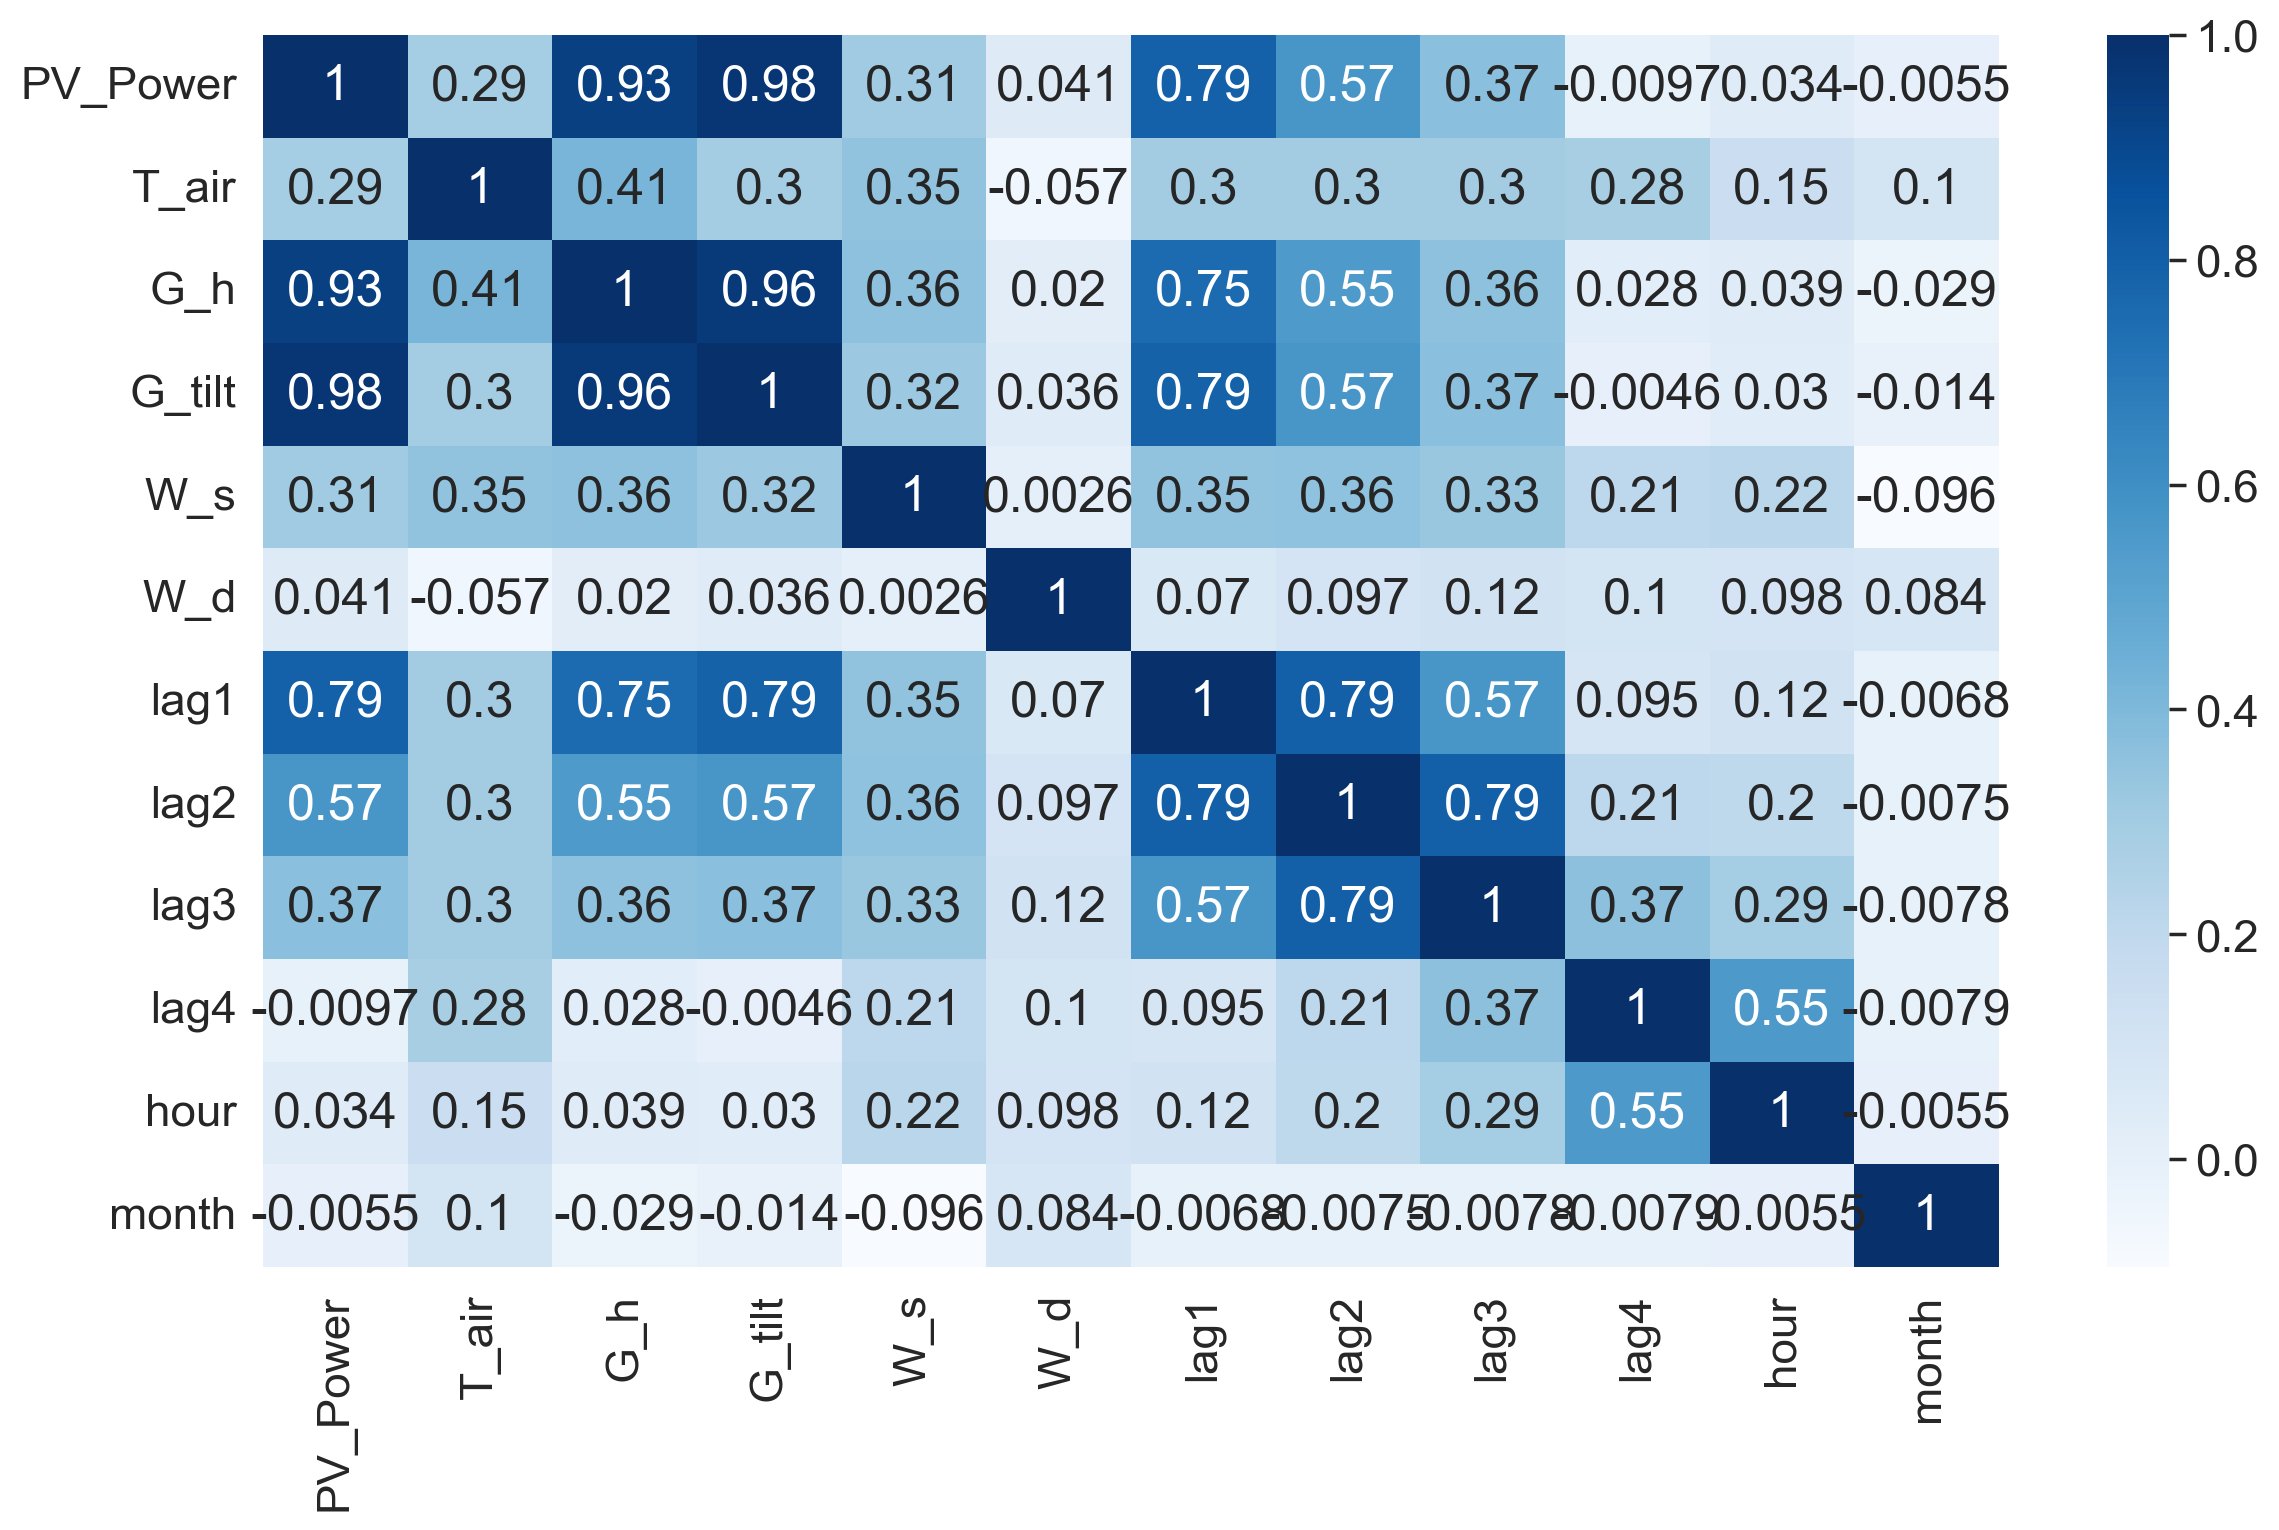

In [17]:
plt.figure(figsize=(14,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues')

In [18]:
spearmanr(df['G_h'], df['G_tilt'])

SignificanceResult(statistic=0.9819831399838086, pvalue=0.0)

In [34]:
# pearson's correlation feature selection for numeric input and numeric output
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
# define feature selection
X = df.values[:, 1:]
Y = df.values[:, 0]
# feature extraction
test = SelectKBest(score_func=f_regression, k=4)
fit = test.fit(X, Y)
# summarize scores
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(df.columns[1:])
print(fit.scores_)
features = fit.transform(X)
# summarize selected features
print(features[0:5,:])
df.columns

Index(['T_air', 'G_h', 'G_tilt', 'W_s', 'W_d', 'lag1', 'lag2', 'lag3', 'lag4',
       'hour', 'month'],
      dtype='object')
[804.087 56912.674 178789.909 922.088 14.922 14813.034 4154.411 1348.764
 0.809 9.990 0.258]
[[0.000 0.000 1.002 1.031]
 [0.100 0.133 0.790 1.002]
 [34.900 86.067 0.826 0.790]
 [148.450 328.050 20.945 0.826]
 [267.500 531.383 76.984 20.945]]


Index(['PV_Power', 'T_air', 'G_h', 'G_tilt', 'W_s', 'W_d', 'lag1', 'lag2',
       'lag3', 'lag4', 'hour', 'month'],
      dtype='object')

In [37]:
# Recursive Feature Elimination

# Feature Extraction with RFE
from pandas import read_csv
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso
array = df.values
X = array[:,1:]
Y = array[:,0]
# feature extraction
model = Lasso()
rfe = RFE(estimator=model, n_features_to_select=3)
fit = rfe.fit(X, Y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)


Num Features: 3
Selected Features: [ True False  True False False  True False False False False False]
Feature Ranking: [1 2 1 9 7 1 3 6 5 4 8]


We can conclude that the T_air, G_tilt, lag1 are the most important features

In [45]:
# Feature Importance
from pandas import read_csv
from sklearn.ensemble import RandomForestRegressor
array = df.values
X = array[:,1:]
Y = array[:,0]
# feature extraction
model = RandomForestRegressor(n_estimators=100)
model.fit(X, Y)
print(model.feature_importances_)


[0.003 0.001 0.960 0.002 0.003 0.018 0.005 0.003 0.002 0.003 0.001]


We are going to use these features for our training model. (T_air, G_tilt, lag1)

# Naive Forecast
The persistence algorithm uses the value at the previous time step (t-1) to predict the expected outcome at the next time step (t+1).



In [35]:
values = pd.DataFrame(pv.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
print(dataframe.head(5))

         t-1         t+1
0        NaN    0.790304
1   0.790304    0.826171
2   0.826171   20.945110
3  20.945110   76.983555
4  76.983555  123.238867


In [36]:
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [38]:
# persistence model
def model_persistence(x):
    return x

In [39]:
# walk-forward validation
from sklearn.metrics import mean_squared_error
from math import sqrt

predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % test_score)


Test RMSE: 27.119


In [ ]:
np.std(test_y)

47.34055229460605

This sets a metric that our new model has to beat.